In [57]:
import (
    "fmt"
    "os"
    "io"
    "bufio"
    
    csv "encoding/csv"
    "strconv"
    "math"


    "image"
    gif "image/gif"

    "gonum.org/v1/plot"
    "gonum.org/v1/plot/plotter"
    "gonum.org/v1/plot/plotutil"
    "gonum.org/v1/plot/vg/draw"
    "gonum.org/v1/plot/vg/vgimg"

)

Data reader.

In [58]:
import gif "image/gif"

In [59]:
const DATA = "../pps.csv"
datafile, err := os.Open(DATA)
if err != nil {
    fmt.Println(err)
}
rdr := csv.NewReader(bufio.NewReader(datafile))

plotdata := make([][]string, 0)
for i :=0;; i ++ {
    record, err := rdr.Read()
    if err == io.EOF {
        break
    }
    if err != nil {
        fmt.Println(err)
    }
    plotdata = append(plotdata, record)
}

In [60]:
const Z = 1.96

// define point with error bar
func pterr(pts plotter.XYs, i int, m, s float64) {
    k := (i - 3) / 2
    j := 4 * k
    x := float64(k)
    pts[j].X = x
    pts[j].Y = m 
    pts[j + 1].X = x
    pts[j + 1].Y = m + Z * s
    pts[j + 2].X = x
    pts[j + 2].Y = m - Z *s
    pts[j + 3].X = x
    pts[j + 3].Y = m
}

// define points and mean
func points(record []string) (float64, float64, plotter.XYs) { 
    mean, err := strconv.ParseFloat(record[1], 64)
    if err != nil {
        fmt.Println(err)
    }
    std, err := strconv.ParseFloat(record[2], 64)
    if err != nil {
        fmt.Println(err)
    }
    pts := make(plotter.XYs, (len(record) - 3) / 2 * 4)
    for i := 3; i != len(record); i += 2 {
        alpha, err := strconv.ParseFloat(record[i], 64)
        if err != nil {
            fmt.Println(err)
        }
        beta, err := strconv.ParseFloat(record[i + 1], 64)
        if err != nil {
            fmt.Println(err)
        }
        m := alpha / (alpha + beta)
        s := math.Sqrt(alpha * beta / ((alpha + beta) * 
                                       (alpha + beta) * 
                                       (alpha + beta + 1)))
        pterr(pts, i, m, s)
    }
    return mean, std, pts
}

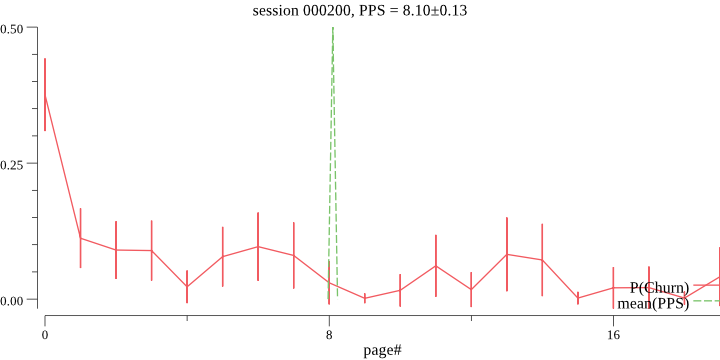

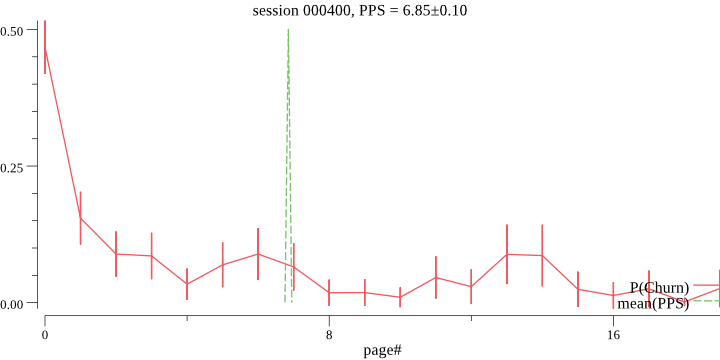

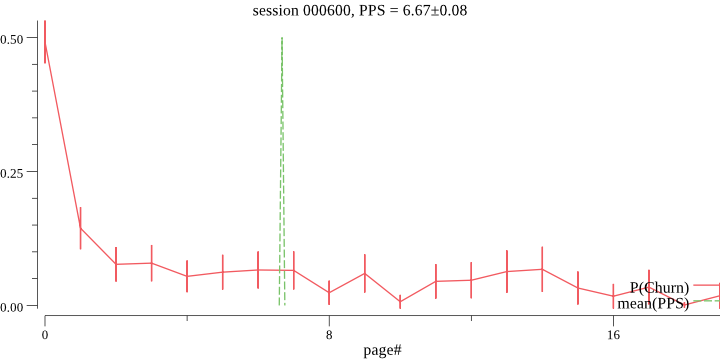

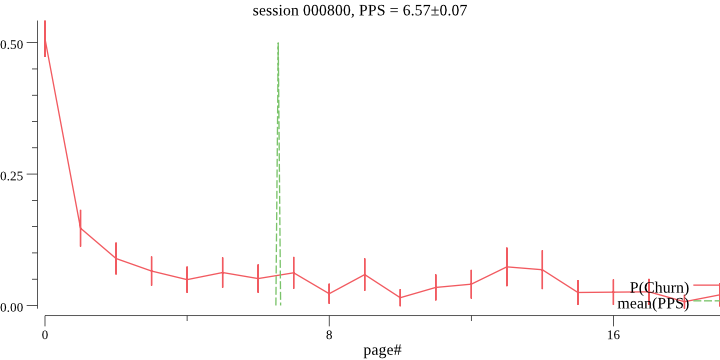

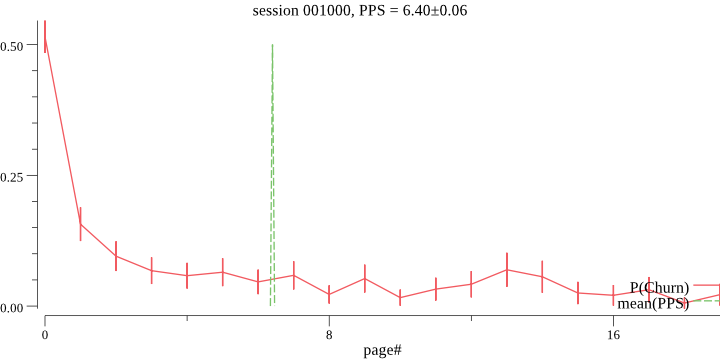

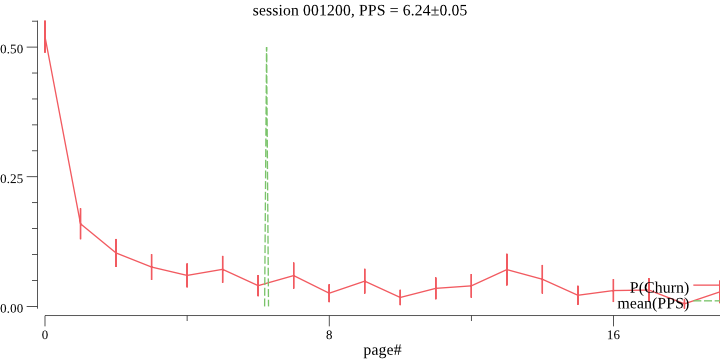

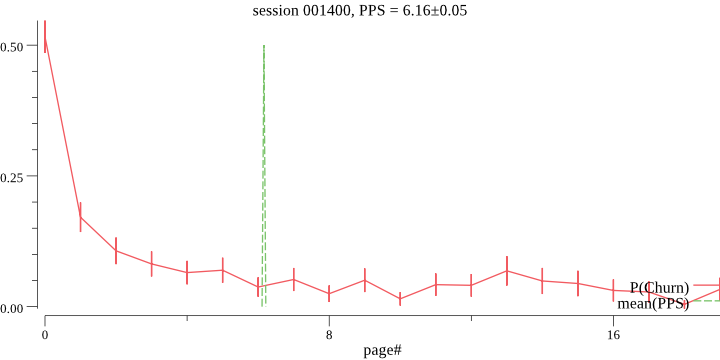

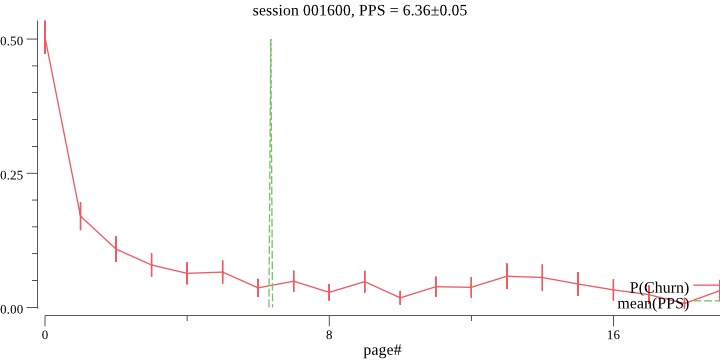

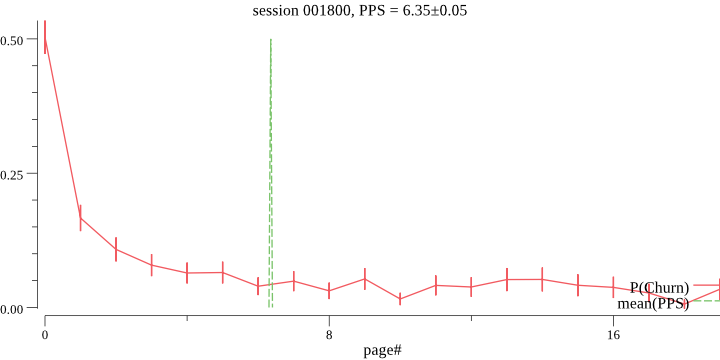

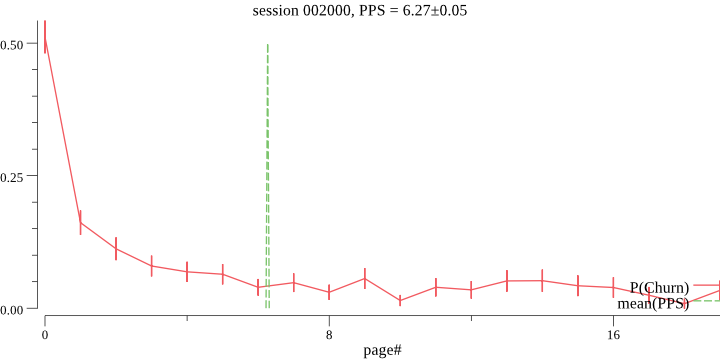

In [61]:
const STEP = 10

for i, record := range plotdata[1:] {
    p, err := plot.New()
   
    mean, std, pts := points(record)
 
    p.Title.Text = fmt.Sprintf("session %v, PPS = %.2f±%.2f", record[0], mean, Z*std)
    p.X.Label.Text = "page#"
    
    plotutil.AddLines(p, 
                      "P(Churn)", pts, 
                      "mean(PPS)", plotter.XYs{{mean - Z*std, 0}, 
                                               {mean, 0.5}, 
                                               {mean + Z*std, 0.}})
    
    
    const dpi = 120

    img := (image.NewRGBA(image.Rect(0, 0, 6*dpi, 3*dpi)))
    c := vgimg.NewWith(vgimg.UseImage(img))
    p.Draw(draw.New(c))
    if (i + 1) % STEP == 0 {
        Display(display.Image(img))
    }
    
    // Write to file.
    f, err := os.Create(fmt.Sprintf("pps-%s.gif", record[0]))
    if err != nil {
        panic(err)
    }
    
    if err := gif.Encode(f, img, nil); err != nil {
        f.Close()
        panic(err)
    }

    if err := f.Close(); err != nil {
        panic(err)
    }
}